In [21]:
#Importing the modules
import pandas as pd
import numpy as np
import os

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [3]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2022-12-23 20:50:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.09MB/s    in 2m 40s  

2022-12-23 20:52:46 (5.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [4]:
#Unzipping the files
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


Mounting the drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading the cleaned train and test data sets from drive

In [6]:
#Reading the processed train dataset
df_train_clean = pd.read_csv('/content/drive/MyDrive/IMDB_NLP/Train_reviews.csv',usecols = ['Review','Review_label'])
#Reading the processed test dataset
df_test_clean = pd.read_csv('/content/drive/MyDrive/IMDB_NLP/Test_reviews.csv',usecols = ['Review','Review_label'])

In [7]:
#Lets have a look at the training data!
df_train_clean

,Review,Review_label
0,This absolutely terrible movie Dont lured Chri...,0.0
1,I known fall asleep films usually due combinat...,0.0
2,Mann photographs Alberta Rocky Mountains super...,0.0
3,This kind film snowy Sunday afternoon rest wor...,1.0
4,As others mentioned women go nude film mostly ...,1.0
...,...,...
24995,I severe problem show several actually A simpl...,0.0
24996,The year 1964 Ernesto Che Guevara Cuban citize...,1.0
24997,Okay So I got back Before I start review let t...,0.0
24998,When I saw trailer TV I surprised In May 2008 ...,0.0


In [8]:
#Lets have a look at the test data!
df_test_clean

,Review,Review_label
0,There films make careers For George Romero NIG...,1.0
1,A blackly comic tale downtrodden priest Nazari...,1.0
2,Scary Movie 14 Epic Movie Date Movie Meet Spar...,0.0
3,Poor Shirley MacLaine tries hard lend gravitas...,0.0
4,As former Erasmus student I enjoyed film much ...,1.0
...,...,...
24995,Feeling Minnesota really road movie thats stil...,0.0
24996,This without doubt one favourite horror films ...,1.0
24997,Most predicable movie Ive ever seenextremely b...,0.0
24998,Its exactly I expected Relaxing humorous enter...,1.0


Creating a dictionary for Glove words

In [9]:
glove_words = dict()

In [10]:
#Creating a function to read the unzipped file to create a dictionary containing words along with their vectors
def glove_dict(dictionary, filename):
    with open(filename, 'r') as f:
          for line in f.readlines():
               line = line.split(' ')
               try:
                  dictionary[line[0]] = np.array(line[1:], dtype=float) 
               except:
                  continue
glove_dict(glove_words, 'glove.6B.200d.txt')

In [11]:
len(glove_words)

400000

LSTM Model requires input in numeric form, so we need to convert the reviews to numbers. 

For that we use Keras Tokenizer.

In [12]:
#Using Tokenizer from Keras
#Initialisaing the tokenizer
tok = Tokenizer(lower = True,split = ' ')    #Converting reviews in lowercase 
#Fitting it to text
tok.fit_on_texts(df_train_clean['Review'].values)

In [13]:
num_words = len(tok.word_index) + 1
num_words

142400

Reviews in training and test data are converted to integers using texts_to_sequences method.

In [14]:
#Training set
X_train = tok.texts_to_sequences(df_train_clean['Review'].values)
#Test set
X_test = tok.texts_to_sequences(df_test_clean['Review'].values)

In [15]:
word_index = tok.word_index

Each of the review in the data may differ in length. So we need to make them of equal length by padding(that is adding 0 if it falls short) or truncating the words.

In [16]:
#Padding set to 200 (Here we have glove dictionary conatining vector for each word with 200 dimensions)
max_length = 200
X_train_padded = pad_sequences(X_train, padding= 'post', maxlen = max_length, truncating = "post")
X_test_padded =  pad_sequences(X_test, padding= 'post', maxlen = max_length, truncating = "post")

In [17]:
#Building an embedding matrix to load into our embedding layer 
embed_matrix = np.zeros((num_words,len(X_train_padded[0])))  # Shape of matrix is given maximum words with each word having 200-dimensional vector
for word, i in  word_index.items():
       embed_vec = glove_words.get(word)  #Getting corresponding vector for each word
       if i < num_words:
           if embed_vec is not None:     #Words not found in glove_words will be zero.
                 embed_matrix[i] = embed_vec

Building LSTM Model

In [18]:
#Building Sequential model
model = Sequential()
model.add(Embedding (num_words,200, input_length = max_length))   #Setting first layer as embedding layer
model.add(LSTM(128,dropout = 0.1))
model.add(Dense(1, activation = 'sigmoid'))

Loading the Glove embeddings into our model

In [19]:
#Assigning embedding matrix as weights
model.layers[0].set_weights([embed_matrix])
#Assigning trainable to False as we are using glove which is pre trained
model.layers[0].trainable = False

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          28480000  
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 28,648,577
Trainable params: 168,577
Non-trainable params: 28,480,000
_________________________________________________________________
None


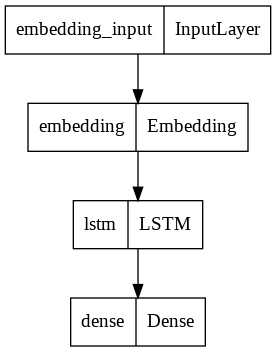

In [22]:
print(model.summary())
plot_model(model)

In [23]:
optimizer = Adam(learning_rate = 0.004)
model.compile(loss = 'binary_crossentropy', optimizer= optimizer ,metrics = ['accuracy'])

In [24]:
y_train = df_train_clean['Review_label']
y_test = df_test_clean['Review_label']

In [25]:
model.history = model.fit(X_train_padded, y_train, batch_size = 64, epochs = 10,validation_data = (X_test_padded, y_test))

Epoch 1/10
391/391 [==============================] - 264s 670ms/step - loss: 0.6855 - accuracy: 0.5274 - val_loss: 0.5726 - val_accuracy: 0.7542
Epoch 2/10
391/391 [==============================] - 265s 678ms/step - loss: 0.4808 - accuracy: 0.7839 - val_loss: 0.3683 - val_accuracy: 0.8402
Epoch 3/10
391/391 [==============================] - 259s 662ms/step - loss: 0.3558 - accuracy: 0.8473 - val_loss: 0.3561 - val_accuracy: 0.8445
Epoch 4/10
391/391 [==============================] - 259s 662ms/step - loss: 0.3791 - accuracy: 0.8352 - val_loss: 0.3497 - val_accuracy: 0.8508
Epoch 5/10
391/391 [==============================] - 262s 670ms/step - loss: 0.3253 - accuracy: 0.8639 - val_loss: 0.3306 - val_accuracy: 0.8572
Epoch 6/10
391/391 [==============================] - 258s 661ms/step - loss: 0.2899 - accuracy: 0.8799 - val_loss: 0.3198 - val_accuracy: 0.8630
Epoch 7/10
391/391 [==============================] - 260s 666ms/step - loss: 0.2565 - accuracy: 0.8973 - val_loss: 0.3198 -

Here the highest validation accuracy acheived is approximately 87%.


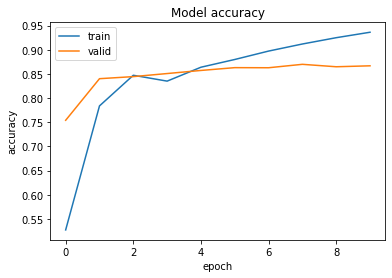

In [26]:
def plot_history(history):
 """Summarize history for accuracy and loss.
 """
 plt.plot(history.history['accuracy'])
 plt.plot(history.history['val_accuracy'])
 plt.title('Model accuracy')
 plt.ylabel('accuracy')
 plt.xlabel('epoch')
 plt.legend(['train', 'valid'], loc='upper left')
 plt.show()

 
plot_history(model.history)





References:


https://colab.research.google.com/drive/1gCCL5Qgl-cT5YhkUWedhOe53VIajFRMO?usp=sharing

https://youtu.be/ivqXiW0X42Q

https://www.kaggle.com/code/imdevskp/imdb-review-classification-lstm-gru-cnn-glove